# 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
from warnings import filterwarnings
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn import metrics as m
from category_encoders import OneHotEncoder,TargetEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import pickle as pkl
filterwarnings('ignore')

# 1.0 Collect Data

In [3]:
dados1 = pd.read_csv('/Users/nando/Comunidade DS/fraud/data/data.csv')
dados1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
print(f'Rows: {dados1.shape[0]} / Columns: {dados1.shape[1]}')

Rows: 6362620 / Columns: 11


In [5]:
dados1 = dados1.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.1,random_state=101))# Stratified sampling

In [6]:
# Granularidade -> Transação

# 2.0 Data Cleaning

In [7]:
dados2 = dados1.copy()

## 2.1 Rename Values and Columns

In [8]:
dados2

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4017003,299,CASH_IN,254790.91,C145646199,16196.00,270986.91,C248136607,524425.01,269634.10,0,0
2193816,185,PAYMENT,7703.07,C680351073,430113.14,422410.07,M1064614924,0.00,0.00,0,0
4901502,349,TRANSFER,1266162.82,C1731035659,169889.28,0.00,C1182036804,2791129.07,4057291.88,0,0
264725,15,PAYMENT,2672.40,C890164085,358982.25,356309.85,M863319277,0.00,0.00,0,0
184708,13,CASH_IN,413698.51,C1708496264,1675441.00,2089139.51,C533475466,979355.07,976934.25,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3220578,250,CASH_OUT,213463.32,C1263272342,213463.32,0.00,C744918576,0.00,115035.59,1,0
286185,15,TRANSFER,164500.81,C1761347420,164500.81,0.00,C383804904,0.00,0.00,1,0
6302451,683,CASH_OUT,73929.99,C652139882,73929.99,0.00,C641860418,1640832.48,1714762.47,1,0
6119236,538,CASH_OUT,1392337.38,C874241747,1392337.38,0.00,C762678995,125815.90,1518153.28,1,0


In [9]:
# CamelCase to snake_case

# Columns
for column in dados2.columns:
    dados2.rename(columns={column:inflection.underscore(column)},inplace=True)
    
# Values
dados2['type'] = dados2['type'].apply(lambda x: inflection.underscore(x))

# Corrigir o snake_case de algumas colunas e usar 'orig' e não 'org'
dados2.rename(columns={'oldbalance_org':'old_balance_orig','newbalance_orig':'new_balance_orig','oldbalance_dest':'old_balance_dest','newbalance_dest':'new_balance_dest'},inplace=True)

## 2.2 Missing Data

In [10]:
dados2.isna().sum()

step                0
type                0
amount              0
name_orig           0
old_balance_orig    0
new_balance_orig    0
name_dest           0
old_balance_dest    0
new_balance_dest    0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 2.3 Data Dtypes

In [11]:
dados2.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
old_balance_orig    float64
new_balance_orig    float64
name_dest            object
old_balance_dest    float64
new_balance_dest    float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

# 3.0 Feature Engineering

In [12]:
dados3 = dados2.copy()

In [13]:
dados3

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
4017003,299,cash_in,254790.91,C145646199,16196.00,270986.91,C248136607,524425.01,269634.10,0,0
2193816,185,payment,7703.07,C680351073,430113.14,422410.07,M1064614924,0.00,0.00,0,0
4901502,349,transfer,1266162.82,C1731035659,169889.28,0.00,C1182036804,2791129.07,4057291.88,0,0
264725,15,payment,2672.40,C890164085,358982.25,356309.85,M863319277,0.00,0.00,0,0
184708,13,cash_in,413698.51,C1708496264,1675441.00,2089139.51,C533475466,979355.07,976934.25,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3220578,250,cash_out,213463.32,C1263272342,213463.32,0.00,C744918576,0.00,115035.59,1,0
286185,15,transfer,164500.81,C1761347420,164500.81,0.00,C383804904,0.00,0.00,1,0
6302451,683,cash_out,73929.99,C652139882,73929.99,0.00,C641860418,1640832.48,1714762.47,1,0
6119236,538,cash_out,1392337.38,C874241747,1392337.38,0.00,C762678995,125815.90,1518153.28,1,0


In [14]:
# Type of destination client
dados3['type_dest'] = dados3['name_dest'].astype(str).str[0].map({'C':'customers','M':'merchants'})

In [15]:
# If the origin account has lost or earned money or if nothing has changed in that transaction
dados3['orig_transaction_status'] = dados3.apply(lambda x: 'orig_lost_money' if x['new_balance_orig']<x['old_balance_orig'] else ('no_change' if x['new_balance_orig']==x['old_balance_orig'] else 'orig_earned_money'),1)

# If the destination account has lost or earned money or if nothing has changed in that transaction
dados3['dest_transaction_status'] = dados3.apply(lambda x: 'dest_lost_money' if x['new_balance_dest']<x['old_balance_dest'] else ('no_change' if x['new_balance_dest']==x['old_balance_dest'] else 'dest_earned_money'),1)

In [16]:
# Orig account has no money after the transaction
dados3['orig_has_no_money'] = dados3['new_balance_orig'].apply(lambda x: 1 if x==0 else 0)

# Dest account had no money before the transaction
dados3['dest_had_no_money'] = dados3['old_balance_dest'].apply(lambda x: 1 if x==0 else 0)

# 4.0 Exploratory Data Analysis

In [17]:
dados4 = dados3.copy()

## 4.1 Descriptive Analysis

### 4.1.1 Numeric Variables

In [18]:
descriptive = dados4.describe().T
descriptive['skew'] = dados4.skew()
descriptive['kurtosis'] = dados4.kurtosis()
descriptive['range'] = dados4.select_dtypes(exclude='object').max()-dados4.select_dtypes(exclude='object').min()
descriptive.round(2)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,range
step,636262.0,243.14,142.30,1.00,155.00,238.00,334.00,7.420000e+02,0.38,0.33,7.410000e+02
amount,636262.0,180936.40,618526.78,0.07,13462.29,75453.32,209223.92,7.117248e+07,32.95,1995.53,7.117248e+07
old_balance_orig,636262.0,842967.24,2907950.30,0.00,0.00,14408.00,107637.86,5.731626e+07,5.21,32.37,5.731626e+07
new_balance_orig,636262.0,864483.37,2943927.97,0.00,0.00,0.00,145724.22,4.731626e+07,5.13,31.42,4.731626e+07
old_balance_dest,636262.0,1106516.72,3357099.72,0.00,0.00,135019.40,948949.93,2.754052e+08,17.89,741.04,2.754052e+08
new_balance_dest,636262.0,1232319.61,3647075.84,0.00,0.00,216127.38,1118695.05,2.866068e+08,17.69,689.46,2.866068e+08
is_fraud,636262.0,0.00,0.04,0.00,0.00,0.00,0.00,1.000000e+00,27.78,769.99,1.000000e+00
is_flagged_fraud,636262.0,0.00,0.00,0.00,0.00,0.00,0.00,1.000000e+00,797.66,636262.00,1.000000e+00
orig_has_no_money,636262.0,0.57,0.50,0.00,0.00,1.00,1.00,1.000000e+00,-0.27,-1.93,1.000000e+00
dest_had_no_money,636262.0,0.42,0.49,0.00,0.00,0.00,1.00,1.000000e+00,0.31,-1.91,1.000000e+00


### 4.1.2 Categorical Variables

In [19]:
dados4.select_dtypes('object').describe().T

,count,unique,top,freq
type,636262,5,cash_out,223407
name_orig,636262,636144,C1860114059,2
name_dest,636262,457008,C1899073220,16
type_dest,636262,2,customers,421823
orig_transaction_status,636262,3,orig_lost_money,287517
dest_transaction_status,636262,3,dest_earned_money,280869


In [20]:
dados4['type'].unique()

array(['cash_in', 'payment', 'transfer', 'cash_out', 'debit'],
      dtype=object)

In [21]:
dados4['orig_transaction_status'].unique()

array(['orig_earned_money', 'orig_lost_money', 'no_change'], dtype=object)

In [22]:
dados4['dest_transaction_status'].unique()

array(['dest_lost_money', 'no_change', 'dest_earned_money'], dtype=object)

In [23]:
dados4['type_dest'].unique()

array(['customers', 'merchants'], dtype=object)

## 4.2 Univariate Analysis

### 4.2.1 Target Feature

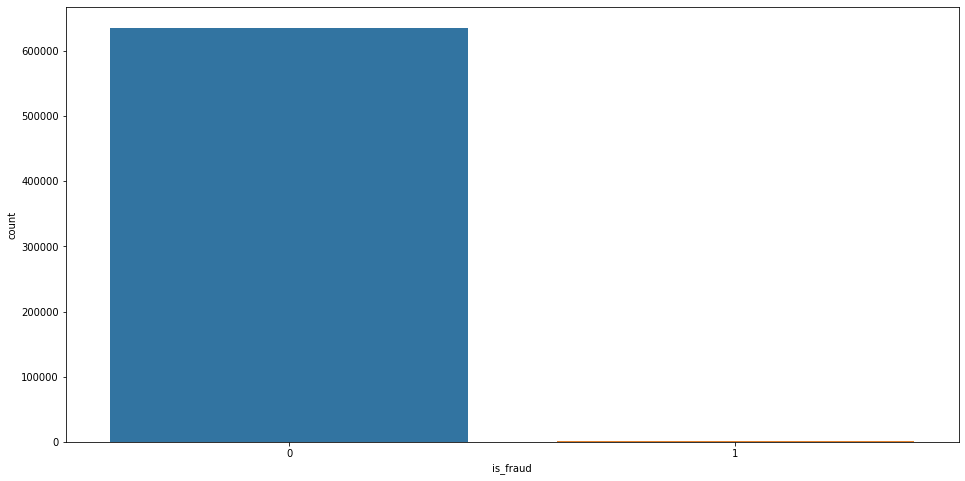

In [24]:
plt.figure(figsize=(16,8))
sns.countplot(dados4['is_fraud']);

In [25]:
dados4['is_fraud'].value_counts(normalize=True)*100

0    99.870965
1     0.129035
Name: is_fraud, dtype: float64

### 4.2.2 Histograms

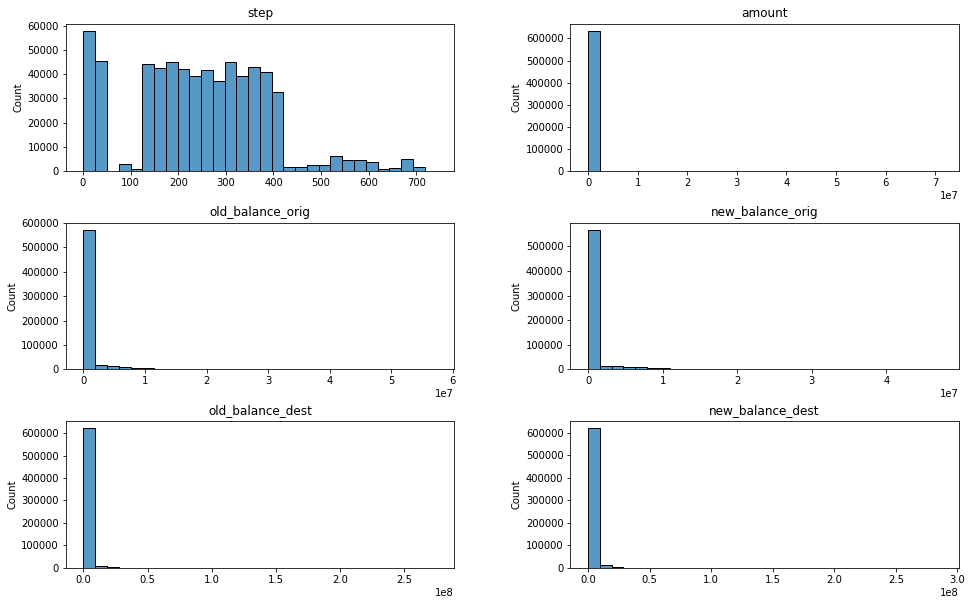

In [26]:
columns = ['step','amount','old_balance_orig','new_balance_orig','old_balance_dest','new_balance_dest']

plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.35,wspace=0.3)
for count,column in enumerate(columns):
    plt.subplot(3,2,count+1)
    ax = sns.histplot(dados4[column],bins=30)
    ax.set_xlabel('')
    ax.set_title(column,fontsize=12,pad=7)

### 4.2.3 Countplots

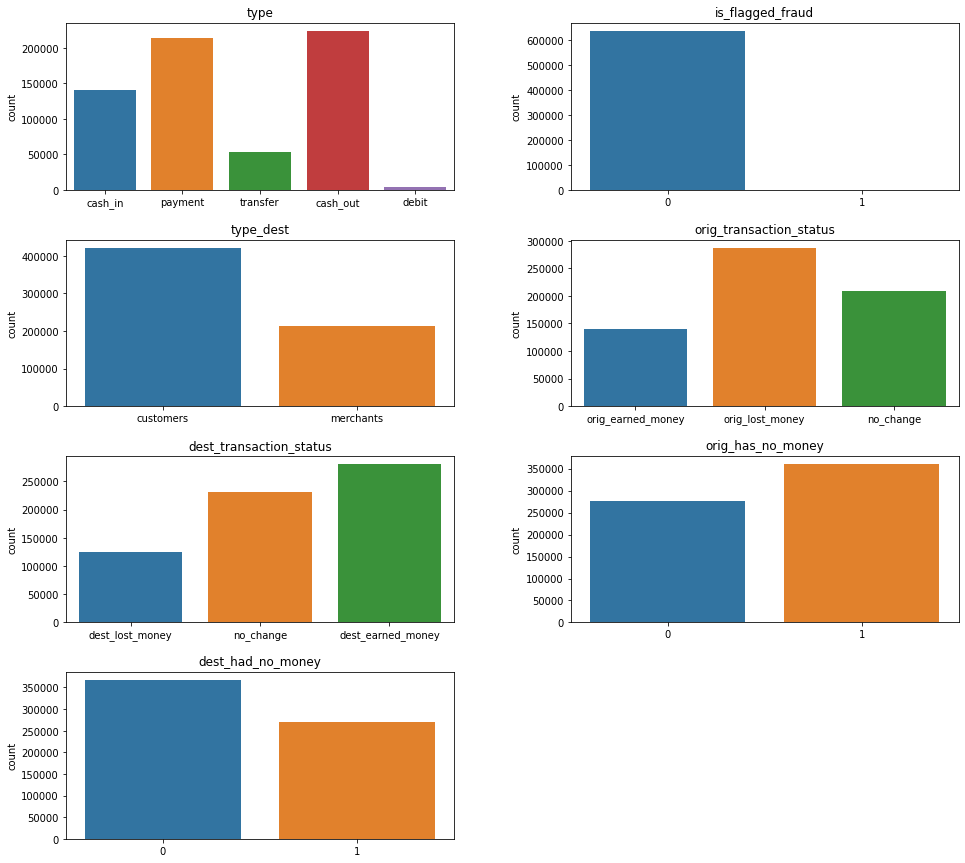

In [27]:
columns = ['type','is_flagged_fraud','type_dest','orig_transaction_status','dest_transaction_status','orig_has_no_money','dest_had_no_money']

plt.figure(figsize=(16,15))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
for count,column in enumerate(columns):
    plt.subplot(4,2,count+1)
    ax = sns.countplot(dados4[column])
    ax.set_xlabel('')
    ax.set_title(column,fontsize=12,pad=7)

### 4.2.4 Investigate 'no_change' transaction

In [28]:
dados4[dados4['orig_transaction_status']=='no_change']

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_dest,orig_transaction_status,dest_transaction_status,orig_has_no_money,dest_had_no_money
308780,16,cash_out,49903.80,C151068873,0.00,0.00,C1685697739,6178628.18,6204277.41,0,0,customers,no_change,dest_earned_money,1,0
2846164,226,cash_out,377703.46,C1214885828,0.00,0.00,C328256588,2425773.11,2803476.57,0,0,customers,no_change,dest_earned_money,1,0
5758300,400,cash_out,352407.54,C891615425,0.00,0.00,C63799985,1347676.69,1700084.23,0,0,customers,no_change,dest_earned_money,1,0
3602619,263,cash_out,63821.64,C1914935320,0.00,0.00,C1319143492,114245.48,178067.12,0,0,customers,no_change,dest_earned_money,1,0
3569354,260,transfer,373514.78,C990180536,0.00,0.00,C1015871257,687632.37,1061147.16,0,0,customers,no_change,dest_earned_money,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829342,163,cash_out,2916.60,C810121305,0.00,0.00,C532913912,855529.91,858446.51,0,0,customers,no_change,dest_earned_money,1,0
732891,37,cash_out,112486.46,C124687089,0.00,0.00,C179706450,257274.47,369760.93,1,0,customers,no_change,dest_earned_money,1,0
479636,19,cash_out,122101.57,C149845822,0.00,0.00,C1200316948,0.00,639940.20,1,0,customers,no_change,dest_earned_money,1,1
694551,36,cash_out,234377.29,C1737133410,0.00,0.00,C877378703,34937.86,269315.15,1,0,customers,no_change,dest_earned_money,1,0


In [29]:
# Saldos da origem que não mudaram!
dados4[dados4['orig_transaction_status']=='no_change'][['old_balance_orig','new_balance_orig']].apply(lambda x: x.value_counts())

,old_balance_orig,new_balance_orig
0.00,208253,208253
350501.24,1,1
4800759.18,1,1
17655792.46,1,1
6509377.51,1,1
149735.97,1,1
4892193.09,1,1


Vemos como tem MUITO mais zero do que qualquer outro valor, pode ser uma espécie de cheque especial, mas não mostra a conta negativa. Realmente não consigo afirmar com o que temos aqui!

In [30]:
# O que aconteceu na conta de destino
dados4[dados4['orig_transaction_status']=='no_change']['dest_transaction_status'].value_counts(normalize=True)

dest_earned_money    0.620069
no_change            0.369050
dest_lost_money      0.010881
Name: dest_transaction_status, dtype: float64

In [31]:
# O que geralmente acontece (compare % to see if there's a significant statistical difference!)
dados4['dest_transaction_status'].value_counts(normalize=True)

dest_earned_money    0.441436
no_change            0.363080
dest_lost_money      0.195484
Name: dest_transaction_status, dtype: float64

In [32]:
# Ver se quando não muda nem em orig nem em dest significa o banco se protegendo e bloqueando fraudes!
# (Pode ser um data leak)
dados4[(dados4['orig_transaction_status']=='no_change')&((dados4['dest_transaction_status']=='no_change'))]['is_fraud'].value_counts(normalize=True)

0    0.999987
1    0.000013
Name: is_fraud, dtype: float64

Não é isso, realmente não sei o que acontece para aparentar que a transação não se efetivou!

Os dados, dispostos como estão, não me permitem assumir nenhuma visão, teria que entender mais sobre com outros departamentos da empresa

## 4.3 Bivariate Analysis

### H1: Todas as transações de fraude são de lost money da origin e earned money do dest

This hypothesis is **TRUE**

A grande maioria das vezes a pessoa perde dinheiro e o fraudador ganha, mas existem alguns casos em que nada acontece!

O que me chama atenção é que a proporção de 'no change' nas fraudes nas conta de destino é quase 50/50, enquanto na de origem é bem menos. Isso pode nos indicar que em fraudes o dinheiro até sai da conta, mas não chega a entrar na do criminoso em 50% das vezes, talvez devido a um sistema de segurança (que parece estar sendo constantemente retratado nos dados e que pode causar data leak), realmente seria importante confirmar isso.

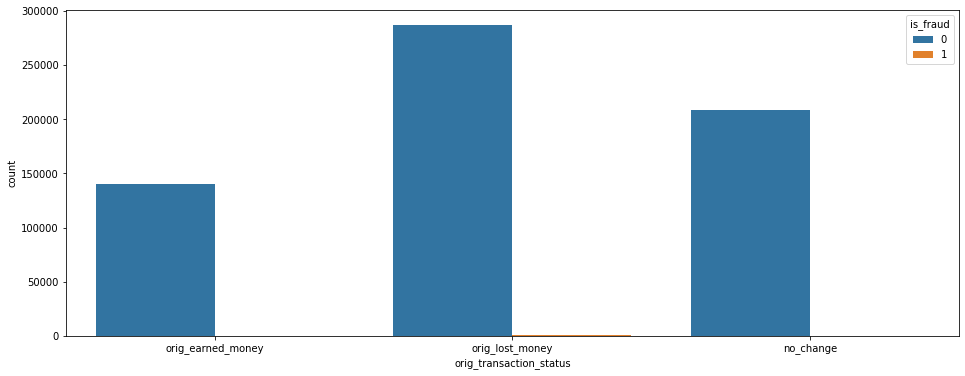

In [33]:
# Origin Balance
plt.figure(figsize=(16,6))
sns.countplot(dados4['orig_transaction_status'],hue=dados4['is_fraud']);

In [34]:
pd.crosstab(dados4['orig_transaction_status'],dados4['is_fraud'])

is_fraud,0,1
orig_transaction_status,,
no_change,208255,4
orig_earned_money,140486,0
orig_lost_money,286700,817


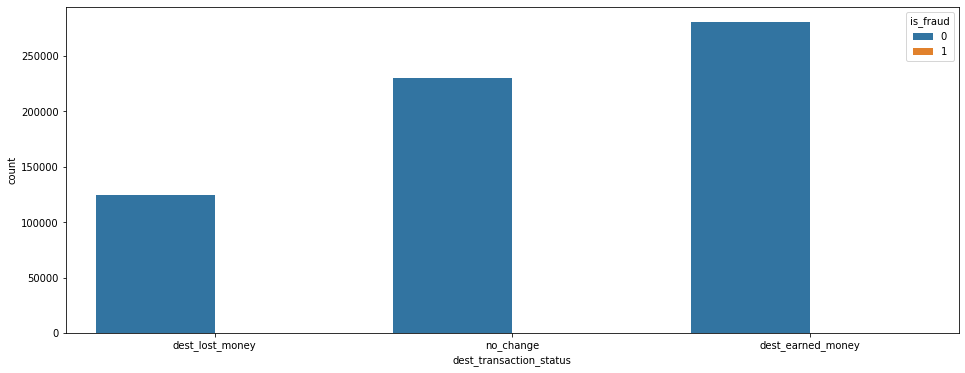

In [35]:
# Dest Balance
plt.figure(figsize=(16,6))
sns.countplot(dados4['dest_transaction_status'],hue=dados4['is_fraud']);

In [36]:
pd.crosstab(dados4['dest_transaction_status'],dados4['is_fraud'])

is_fraud,0,1
dest_transaction_status,,
dest_earned_money,280466,403
dest_lost_money,124379,0
no_change,230596,418


### H2: As fraudes geralmente acontecem através de transferências bancárias

This hypothesis is **FALSE**

Não só transferências, mas também por saques, sendo uma proporção bem equilibrada! Essa feature parece dividir bem nosso dataset!

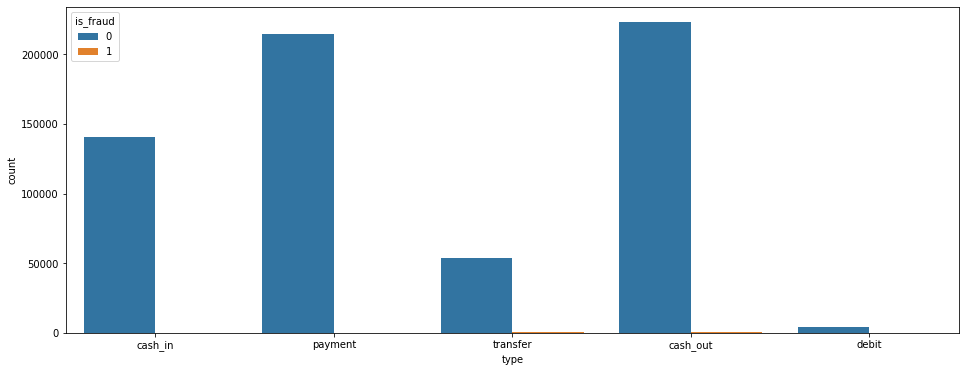

In [37]:
plt.figure(figsize=(16,6))
sns.countplot(dados4['type'],hue=dados4['is_fraud']);

In [38]:
pd.crosstab(dados4['type'],dados4['is_fraud'])

is_fraud,0,1
type,,
cash_in,140489,0
cash_out,223006,401
debit,4098,0
payment,214439,0
transfer,53409,420


### H3: Os fraudadores utilizam contas de pessoas físicas para receber o dinheiro.

This hypothesis is **TRUE**

Isso pode ser bastante importante no modelo lá na frente, pois divide bem nosso espaço de dados!

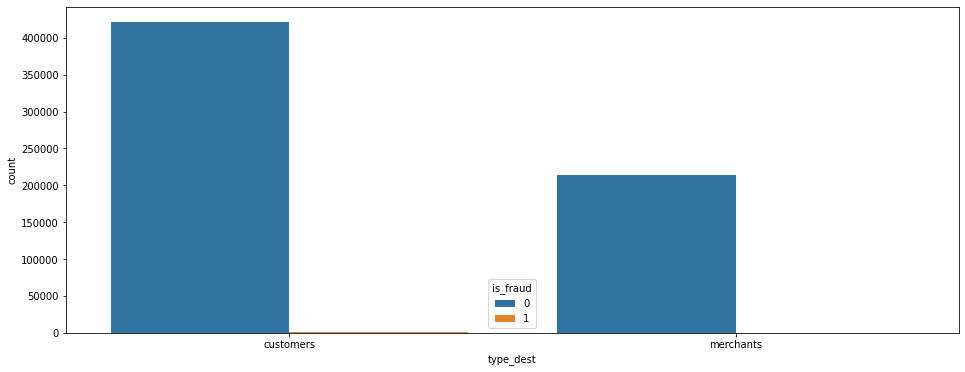

In [39]:
plt.figure(figsize=(16,6))
sns.countplot(dados4['type_dest'],hue=dados4['is_fraud']);

In [40]:
pd.crosstab(dados4['type_dest'],dados4['is_fraud'])

is_fraud,0,1
type_dest,,
customers,421002,821
merchants,214439,0


### H4: Os fraudadores sempre pegam todo o dinheiro das vítimas

This hypothesis is **FALSE**

A grande maioria dos casos sim, mas existem casos que o fraudador não tirou todo o dinheiro da vítima. O que me parece estranho são que os valores são sempre iguais, a não ser em um caso, além disso, todas as vezes esse dinheiro não entrou na conta de destino!

In [41]:
# Tirou todo o dinheiro da vítima
dados4[(dados4['is_fraud']==1)&(dados4['new_balance_orig']==0)]

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_dest,orig_transaction_status,dest_transaction_status,orig_has_no_money,dest_had_no_money
6281788,650,cash_out,230652.43,C821616305,230652.43,0.0,C1559145787,55063.86,285716.30,1,0,customers,orig_lost_money,dest_earned_money,1,0
6118831,537,transfer,266546.68,C1561774472,266546.68,0.0,C351398995,0.00,0.00,1,0,customers,orig_lost_money,no_change,1,1
5188005,363,cash_out,2115503.99,C429080055,2115503.99,0.0,C1734499928,0.00,2115503.99,1,0,customers,orig_lost_money,dest_earned_money,1,1
3132355,236,cash_out,968651.23,C1843014674,968651.23,0.0,C137145524,0.00,719852.88,1,0,customers,orig_lost_money,dest_earned_money,1,1
6273160,632,transfer,82209.71,C2014216295,82209.71,0.0,C2066467731,0.00,0.00,1,0,customers,orig_lost_money,no_change,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220578,250,cash_out,213463.32,C1263272342,213463.32,0.0,C744918576,0.00,115035.59,1,0,customers,orig_lost_money,dest_earned_money,1,1
286185,15,transfer,164500.81,C1761347420,164500.81,0.0,C383804904,0.00,0.00,1,0,customers,orig_lost_money,no_change,1,1
6302451,683,cash_out,73929.99,C652139882,73929.99,0.0,C641860418,1640832.48,1714762.47,1,0,customers,orig_lost_money,dest_earned_money,1,0
6119236,538,cash_out,1392337.38,C874241747,1392337.38,0.0,C762678995,125815.90,1518153.28,1,0,customers,orig_lost_money,dest_earned_money,1,0


In [42]:
# Não tirou todo o dinheiro da vítima
dados4[(dados4['is_fraud']==1)&(dados4['new_balance_orig']!=0)]

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_dest,orig_transaction_status,dest_transaction_status,orig_has_no_money,dest_had_no_money
6266407,617,transfer,10000000.00,C1255348086,32542664.27,22542664.27,C103172881,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
3247293,250,transfer,10000000.00,C2099141021,21343002.08,11343002.08,C1733297456,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
1707589,160,transfer,10000000.00,C313051938,37670038.08,27670038.08,C2055653883,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
1237395,134,transfer,10000000.00,C426632957,13892156.30,3892156.30,C48103061,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
6266409,617,transfer,10000000.00,C1930318116,22542664.27,12542664.27,C1923492040,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
6100676,523,transfer,10000000.00,C1800046297,15999376.79,5999376.79,C125702772,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
6362452,730,transfer,10000000.00,C726730575,57316255.05,47316255.05,C1364745638,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
6295600,670,transfer,10000000.00,C2085303535,12113271.99,2113271.99,C1010370571,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
6362528,736,transfer,10000000.00,C412961249,11314660.84,1314660.84,C253674970,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1
6296010,671,transfer,10000000.00,C475879190,23441041.46,13441041.46,C1395082788,0.0,0.0,1,0,customers,orig_lost_money,no_change,0,1


### H5: Geralmente as contas dos fraudadores está vazia antes de receber a o dinheiro da fraude

This hypothesis is **FALSE**

Na maioria dos casos sim (~66%), mas não em todos. Há algumas vezes que os valores que há nas contas já são enormes!

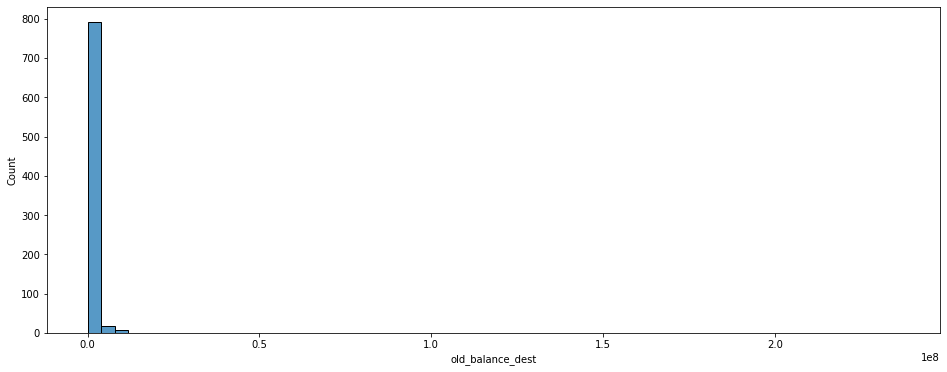

In [43]:
plt.figure(figsize=(16,6))
sns.histplot(dados4[dados4['is_fraud']==1]['old_balance_dest'],bins=60);

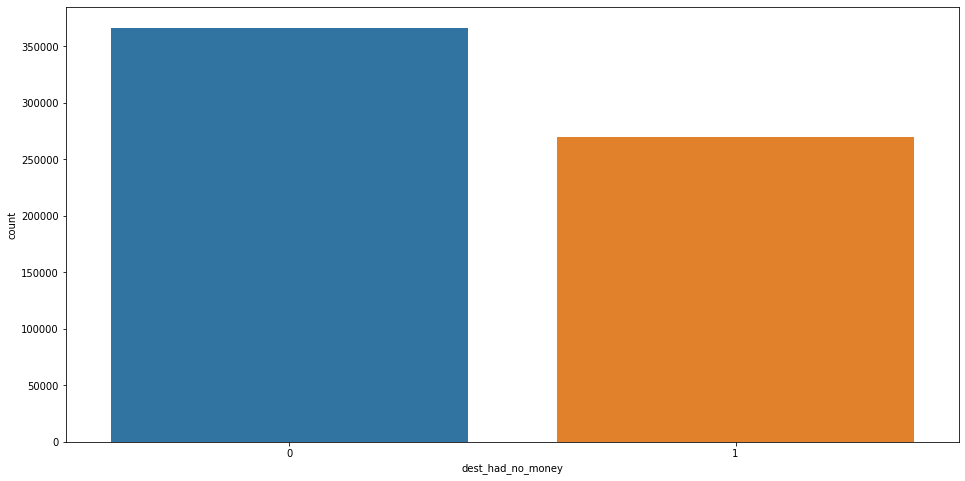

In [44]:
plt.figure(figsize=(16,8))
sns.countplot(dados4['dest_had_no_money']);

In [45]:
# Contas Vazias
dados4[(dados4['is_fraud']==1) & (dados4['old_balance_dest']==0)]

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_dest,orig_transaction_status,dest_transaction_status,orig_has_no_money,dest_had_no_money
6118831,537,transfer,266546.68,C1561774472,266546.68,0.0,C351398995,0.0,0.00,1,0,customers,orig_lost_money,no_change,1,1
5188005,363,cash_out,2115503.99,C429080055,2115503.99,0.0,C1734499928,0.0,2115503.99,1,0,customers,orig_lost_money,dest_earned_money,1,1
3132355,236,cash_out,968651.23,C1843014674,968651.23,0.0,C137145524,0.0,719852.88,1,0,customers,orig_lost_money,dest_earned_money,1,1
6273160,632,transfer,82209.71,C2014216295,82209.71,0.0,C2066467731,0.0,0.00,1,0,customers,orig_lost_money,no_change,1,1
4991601,352,transfer,166456.54,C2019110541,166456.54,0.0,C2098382104,0.0,0.00,1,0,customers,orig_lost_money,no_change,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6279188,643,cash_out,4222595.06,C4856718,4222595.06,0.0,C488060391,0.0,4222595.06,1,0,customers,orig_lost_money,dest_earned_money,1,1
1678626,159,transfer,301193.32,C2089040405,301193.32,0.0,C1669420376,0.0,0.00,1,0,customers,orig_lost_money,no_change,1,1
1141253,131,transfer,7476725.66,C452889653,7476725.66,0.0,C1784013165,0.0,0.00,1,0,customers,orig_lost_money,no_change,1,1
3220578,250,cash_out,213463.32,C1263272342,213463.32,0.0,C744918576,0.0,115035.59,1,0,customers,orig_lost_money,dest_earned_money,1,1


In [46]:
(dados4[dados4['is_fraud']==1]['old_balance_dest']==0).sum()/dados4[dados4['is_fraud']==1].shape[0]

0.6601705237515225

In [47]:
# Contas já com dinheiro
dados4[(dados4['is_fraud']==1) & (dados4['old_balance_dest']!=0)]

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_dest,orig_transaction_status,dest_transaction_status,orig_has_no_money,dest_had_no_money
6281788,650,cash_out,230652.43,C821616305,230652.43,0.0,C1559145787,55063.86,285716.30,1,0,customers,orig_lost_money,dest_earned_money,1,0
2801142,224,cash_out,8752000.36,C333838421,8752000.36,0.0,C977281429,2914790.85,11666791.20,1,0,customers,orig_lost_money,dest_earned_money,1,0
6259927,603,cash_out,2319926.01,C1629072698,2319926.01,0.0,C1470265305,843706.68,3163632.69,1,0,customers,orig_lost_money,dest_earned_money,1,0
1699587,159,cash_out,474052.54,C642633931,474052.54,0.0,C372032326,29256.42,503308.95,1,0,customers,orig_lost_money,dest_earned_money,1,0
1030464,66,cash_out,272791.44,C1671353324,272791.44,0.0,C1524911570,715267.02,988058.46,1,0,customers,orig_lost_money,dest_earned_money,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030476,66,cash_out,2322909.69,C548911578,2322909.69,0.0,C1075176822,875613.05,3198522.74,1,0,customers,orig_lost_money,dest_earned_money,1,0
6166271,551,cash_out,3774777.76,C1440842391,3774777.76,0.0,C1163108586,597455.51,4372233.27,1,0,customers,orig_lost_money,dest_earned_money,1,0
6302451,683,cash_out,73929.99,C652139882,73929.99,0.0,C641860418,1640832.48,1714762.47,1,0,customers,orig_lost_money,dest_earned_money,1,0
6119236,538,cash_out,1392337.38,C874241747,1392337.38,0.0,C762678995,125815.90,1518153.28,1,0,customers,orig_lost_money,dest_earned_money,1,0


In [48]:
(dados4[dados4['is_fraud']==1]['old_balance_dest']!=0).sum()/dados4[dados4['is_fraud']==1].shape[0]

0.3398294762484775

## 4.4 Multivariate Analysis

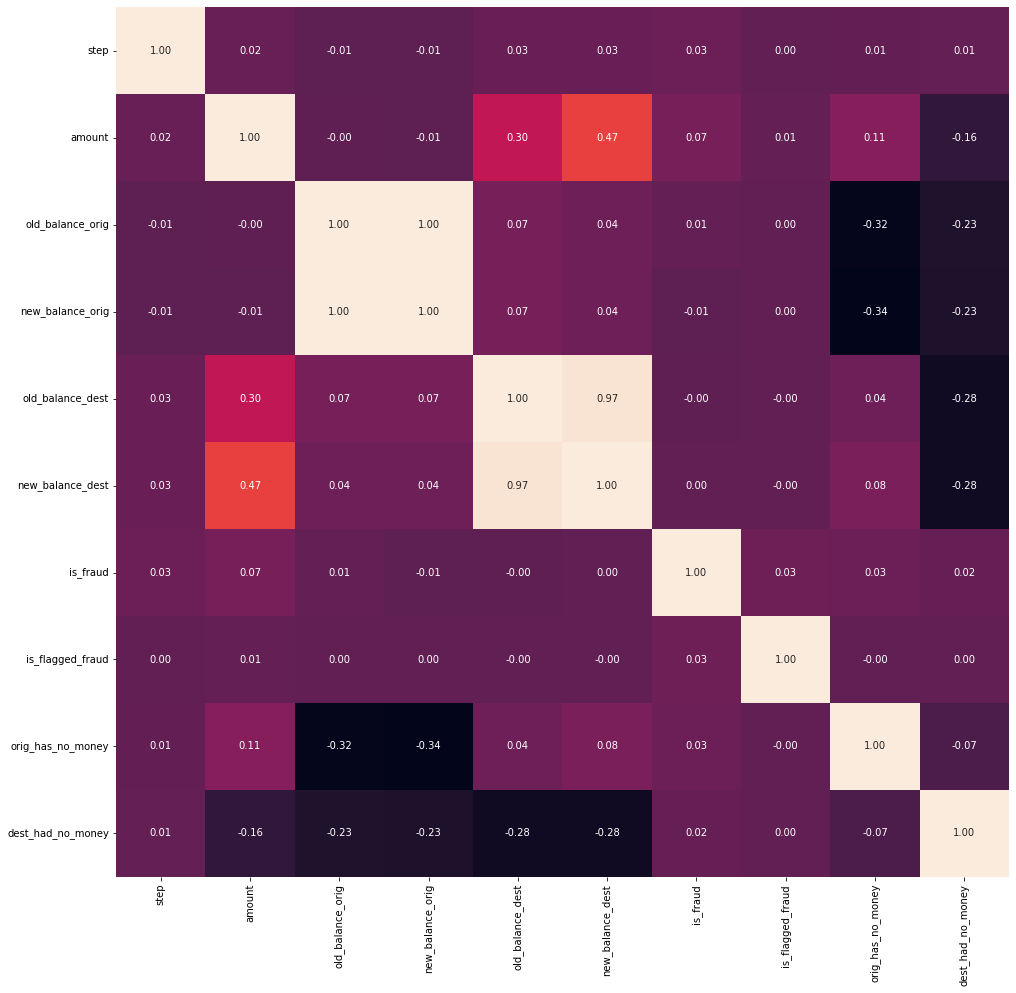

In [49]:
plt.figure(figsize=(16,16))
sns.heatmap(dados4.corr(),annot=True,fmt='.2f',cbar=False);

# 5.0 Data Filtering

In [50]:
dados5 = dados4.copy()

In [51]:
# Não vou modelar com isso, não é o que eu quero modelar, que é o comportamento de uma transação fraudulenta!
# Pode overfitar o modelo! 
dados5.drop(['name_orig','name_dest'],1,inplace=True)

# 6.0 Data Preparation

In [52]:
dados6 = dados5.copy()

## 6.1 Split Data

In [53]:
x,y = dados6.drop('is_fraud',1),dados6['is_fraud']
x_train_val,x_test,y_train_val,y_test = train_test_split(x,y,test_size=0.1,random_state=101,stratify=y)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=101,stratify=y_train_val)

## 6.2 Encoding

In [54]:
# type (multiclass)
ohe = OneHotEncoder(cols=['type'],use_cat_names=True)
ohe.fit(x_train)
x_train = ohe.transform(x_train).drop('type_debit',1) # avoid dummy trap
x_val = ohe.transform(x_val).drop('type_debit',1) # avoid dummy trap
x_test = ohe.transform(x_test).drop('type_debit',1) # avoid dummy trap
pkl.dump(ohe,open('/Users/nando/Comunidade DS/fraud/deploy/local_deploy/pkl/ohe.pkl','wb'))
pkl.dump(ohe,open('/Users/nando/Comunidade DS/fraud/deploy/cloud_deploy/pkl/ohe.pkl','wb'))

# type_dest (binary)
le = LabelEncoder()
le.fit(x_train['type_dest'])
x_train['type_dest'] = le.transform(x_train['type_dest'])
x_val['type_dest'] = le.transform(x_val['type_dest'])
x_test['type_dest'] = le.transform(x_test['type_dest'])
pkl.dump(le,open('/Users/nando/Comunidade DS/fraud/deploy/local_deploy/pkl/le.pkl','wb'))
pkl.dump(le,open('/Users/nando/Comunidade DS/fraud/deploy/cloud_deploy/pkl/le.pkl','wb'))

# orig_transaction_status (ordinal)
ordinal_map = {'orig_earned_money':1, 'orig_lost_money':-1, 'no_change':0}
x_train['orig_transaction_status'] = x_train['orig_transaction_status'].map(ordinal_map)
x_val['orig_transaction_status'] = x_val['orig_transaction_status'].map(ordinal_map)
x_test['orig_transaction_status'] = x_test['orig_transaction_status'].map(ordinal_map)

# dest_transaction_status (ordinal)
ordinal_map = {'dest_earned_money':1, 'dest_lost_money':-1, 'no_change':0}
x_train['dest_transaction_status'] = x_train['dest_transaction_status'].map(ordinal_map)
x_val['dest_transaction_status'] = x_val['dest_transaction_status'].map(ordinal_map)
x_test['dest_transaction_status'] = x_test['dest_transaction_status'].map(ordinal_map)

## 6.3 Rebalance

In [55]:
combine = SMOTE(n_jobs=-1)
x_train,y_train = combine.fit_resample(x_train,y_train)

## 6.4 Rescale

In [56]:
columns = ['step', 'type_transfer', 'type_cash_out', 'type_payment','type_cash_in', 'amount', 'old_balance_orig', 'new_balance_orig','old_balance_dest', 'new_balance_dest', 'is_flagged_fraud', 'type_dest','orig_transaction_status', 'dest_transaction_status','orig_has_no_money', 'dest_had_no_money']
mms = MinMaxScaler()
mms.fit(x_train)
x_train = pd.DataFrame(mms.transform(x_train),columns=columns)
x_val = pd.DataFrame(mms.transform(x_val),columns=columns)
x_test = pd.DataFrame(mms.transform(x_test),columns=columns)
pkl.dump(mms,open('/Users/nando/Comunidade DS/fraud/deploy/local_deploy/pkl/mms.pkl','wb'))
pkl.dump(mms,open('/Users/nando/Comunidade DS/fraud/deploy/cloud_deploy/pkl/mms.pkl','wb'))

## 6.5 Feature Selection

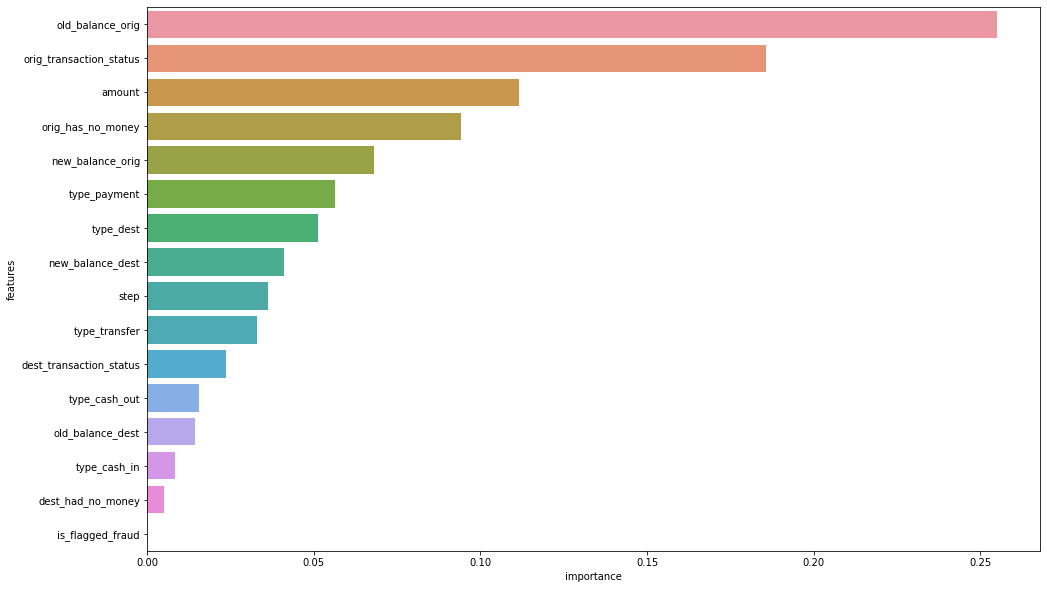

In [57]:
rf = RandomForestClassifier(n_jobs=-1,class_weight='balanced')
rf.fit(x_train,y_train)

aux = pd.DataFrame([x_train.columns,rf.feature_importances_]).T
aux = aux.rename(columns={0:'features',1:'importance'})
aux = aux.sort_values(by='importance',ascending=False)

plt.figure(figsize=(16,10))
sns.barplot(x=aux['importance'],y=aux['features']);

In [58]:
cols_selected = ['step','old_balance_orig','new_balance_dest','dest_transaction_status','orig_transaction_status','amount','type_payment','type_transfer','type_dest','orig_has_no_money']

In [59]:
#cols_selected = x_train.columns.difference(['is_flagged_fraud','dest_had_no_money','type_cash_in','old_balance_dest','type_cash_out','dest_transaction_status'])
x_train = x_train[cols_selected]
x_val = x_val[cols_selected]
x_test = x_test[cols_selected]

# 7.0 Model Selection and Evaluation

## 7.1 Hold-Out

In [230]:
def holdout_results(model,x_train,y_train,x_test,y_test):
    
    model.fit(x_train,y_train)
    
    y_pred = model.predict(x_test)
    accuracy = m.accuracy_score(y_test,y_pred)
    precision = m.precision_score(y_test,y_pred)
    recall = m.recall_score(y_test,y_pred)
    f1_score = m.f1_score(y_test,y_pred)
    roc_auc = m.roc_auc_score(y_test,y_pred)
    
    print('Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nF1 Score: {:.3f}\nROC AUC: {:.3f}'.format(accuracy,precision,recall,f1_score,roc_auc))

### 7.1.1 Decision Tree

In [231]:
holdout_results(DecisionTreeClassifier(),x_train,y_train,x_val,y_val)

Accuracy: 0.999
Precision: 0.555
Recall: 0.858
F1 Score: 0.674
ROC AUC: 0.929


### 7.1.2 Logistic Regression

In [232]:
holdout_results(LogisticRegression(class_weight='balanced'),x_train,y_train,x_val,y_val)

Accuracy: 0.869
Precision: 0.009
Recall: 0.946
F1 Score: 0.018
ROC AUC: 0.908


### 7.1.3 Naive Bayes

In [233]:
holdout_results(GaussianNB(),x_train,y_train,x_val,y_val)

Accuracy: 0.808
Precision: 0.007
Recall: 0.993
F1 Score: 0.013
ROC AUC: 0.900


In [234]:
holdout_results(MultinomialNB(),x_train,y_train,x_val,y_val)

Accuracy: 0.725
Precision: 0.005
Recall: 0.993
F1 Score: 0.009
ROC AUC: 0.859


### 7.1.4 Random Forest

In [235]:
holdout_results(RandomForestClassifier(class_weight='balanced',n_jobs=-1),x_train,y_train,x_val,y_val)

Accuracy: 0.999
Precision: 0.603
Recall: 0.932
F1 Score: 0.732
ROC AUC: 0.966


### 7.1.5 LGBM

In [236]:
holdout_results(LGBMClassifier(class_weight='balanced',n_jobs=-1),x_train,y_train,x_val,y_val)

Accuracy: 0.997
Precision: 0.337
Recall: 0.986
F1 Score: 0.503
ROC AUC: 0.992


### 7.1.6 XGBoost

In [237]:
holdout_results(XGBClassifier(scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1],n_jobs=-1),x_train,y_train,x_val,y_val)

Accuracy: 0.999
Precision: 0.505
Recall: 0.980
F1 Score: 0.667
ROC AUC: 0.989


## 7.2 Cross Validation

In [238]:
def data_preparation(x_train,x_test,y_train,y_test):
    
    ## 6.2 Encoding
    # type (multiclass)
    ohe = OneHotEncoder(cols=['type'],use_cat_names=True)
    ohe.fit(x_train)
    x_train = ohe.transform(x_train).drop('type_debit',1) # avoid dummy trap
    x_test = ohe.transform(x_test).drop('type_debit',1) # avoid dummy trap

    # type_dest (binary)
    le = LabelEncoder()
    le.fit(x_train['type_dest'])
    x_train['type_dest'] = le.transform(x_train['type_dest'])
    x_test['type_dest'] = le.transform(x_test['type_dest'])

    # orig_transaction_status (ordinal)
    ordinal_map = {'orig_earned_money':2, 'orig_lost_money':1, 'no_change':0}
    x_train['orig_transaction_status'] = x_train['orig_transaction_status'].map(ordinal_map)
    x_test['orig_transaction_status'] = x_test['orig_transaction_status'].map(ordinal_map)
    
    # dest_transaction_status (ordinal)
    ordinal_map = {'dest_earned_money':1, 'dest_lost_money':-1, 'no_change':0}
    x_train['dest_transaction_status'] = x_train['dest_transaction_status'].map(ordinal_map)
    x_test['dest_transaction_status'] = x_test['dest_transaction_status'].map(ordinal_map)

    ## 6.3 Rebalance
    combine = SMOTE(n_jobs=-1)
    x_train,y_train = combine.fit_resample(x_train,y_train)

    ## 6.4 Rescale
    columns = ['step', 'type_transfer', 'type_cash_out', 'type_payment','type_cash_in', 'amount', 'old_balance_orig', 'new_balance_orig','old_balance_dest', 'new_balance_dest', 'is_flagged_fraud', 'type_dest','orig_transaction_status', 'dest_transaction_status','orig_has_no_money', 'dest_had_no_money']
    mms = MinMaxScaler()
    mms.fit(x_train)
    x_train = pd.DataFrame(mms.transform(x_train),columns=columns)
    x_test = pd.DataFrame(mms.transform(x_test),columns=columns)

    ## 6.5 Feature Selection
    cols_selected =['step','old_balance_orig','new_balance_dest','dest_transaction_status','orig_transaction_status','amount','type_payment','type_transfer','type_dest','orig_has_no_money']
    x_train = x_train[cols_selected]
    x_test = x_test[cols_selected]
    
    return x_train,x_test,y_train,y_test

In [239]:
def cross_validation(model,x,y,cv_splitter):
    accuracy,precision,recall,f1_score,roc_auc = [],[],[],[],[]
    for fold, (train_index,test_index) in enumerate(cv_splitter.split(x,y)):
        print(f'Fold nº {fold+1}!')
        x_train,y_train,x_test,y_test = x.loc[train_index],y.loc[train_index],x.loc[test_index],y.loc[test_index]
        
        x_train,x_test,y_train,y_test = data_preparation(x_train,x_test,y_train,y_test)

        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)

        accuracy.append(m.accuracy_score(y_test,y_pred))
        precision.append(m.precision_score(y_test,y_pred))
        recall.append(m.recall_score(y_test,y_pred))
        f1_score.append(m.f1_score(y_test,y_pred))
        roc_auc.append(m.roc_auc_score(y_test,y_pred))

    print('\nAccuracy: {:.3f} +/- {:.3f}\nPrecision: {:.3f} +/- {:.3f}\nRecall: {:.3f} +/- {:.3f}\nF1 Score: {:.3f} +/- {:.3f}\nROC AUC: {:.3f} +/- {:.3f}'.format(np.mean(accuracy),np.std(accuracy),np.mean(precision),np.std(precision),np.mean(recall),np.std(recall),np.mean(f1_score),np.std(f1_score),np.mean(roc_auc),np.std(roc_auc)))

### 7.1.1 Decision Tree

In [243]:
cross_validation(DecisionTreeClassifier(),x.reset_index(drop=True),y.reset_index(drop=True),StratifiedKFold(n_splits=3))

Fold nº 1!
Fold nº 2!
Fold nº 3!

Accuracy: 0.999 +/- 0.000
Precision: 0.565 +/- 0.034
Recall: 0.912 +/- 0.006
F1 Score: 0.697 +/- 0.026
ROC AUC: 0.956 +/- 0.003


In [244]:
cross_validation(DecisionTreeClassifier(),x.reset_index(drop=True),y.reset_index(drop=True),StratifiedKFold(n_splits=3))

Fold nº 1!
Fold nº 2!
Fold nº 3!

Accuracy: 0.999 +/- 0.000
Precision: 0.568 +/- 0.029
Recall: 0.907 +/- 0.003
F1 Score: 0.698 +/- 0.022
ROC AUC: 0.953 +/- 0.002


### 7.1.2 Random Forest

In [245]:
cross_validation(RandomForestClassifier(n_jobs=-1),x.reset_index(drop=True),y.reset_index(drop=True),StratifiedKFold(n_splits=3))

Fold nº 1!
Fold nº 2!
Fold nº 3!

Accuracy: 0.999 +/- 0.000
Precision: 0.592 +/- 0.010
Recall: 0.927 +/- 0.010
F1 Score: 0.722 +/- 0.007
ROC AUC: 0.963 +/- 0.005


### 7.1.3 LGBM

In [246]:
cross_validation(LGBMClassifier(),x.reset_index(drop=True),y.reset_index(drop=True),StratifiedKFold(n_splits=3))

Fold nº 1!
Fold nº 2!
Fold nº 3!

Accuracy: 0.998 +/- 0.000
Precision: 0.343 +/- 0.012
Recall: 0.976 +/- 0.012
F1 Score: 0.507 +/- 0.012
ROC AUC: 0.987 +/- 0.006


### 7.1.4 XGBoost

In [247]:
cross_validation(XGBClassifier(),x.reset_index(drop=True),y.reset_index(drop=True),StratifiedKFold(n_splits=3))

Fold nº 1!
Fold nº 2!
Fold nº 3!

Accuracy: 0.999 +/- 0.000
Precision: 0.507 +/- 0.019
Recall: 0.973 +/- 0.012
F1 Score: 0.666 +/- 0.013
ROC AUC: 0.986 +/- 0.006


# 8.0 Hyperparameter Fine Tuning

In [60]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(x_train,y_train)
pkl.dump(model,open('/Users/nando/Comunidade DS/fraud/deploy/local_deploy/pkl/model.pkl','wb'))
pkl.dump(model,open('/Users/nando/Comunidade DS/fraud/deploy/cloud_deploy/pkl/model.pkl','wb'))

# 9.0 Error and Business Interpretation

## 9.1 Final Test

In [61]:
y_pred = model.predict(x_test)

accuracy = m.accuracy_score(y_test,y_pred)
precision = m.precision_score(y_test,y_pred)
recall = m.recall_score(y_test,y_pred)
f1_score = m.f1_score(y_test,y_pred)
roc_auc = m.roc_auc_score(y_test,y_pred)

print('Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nF1 Score: {:.3f}\nROC AUC: {:.3f}'.format(accuracy,precision,recall,f1_score,roc_auc))

Accuracy: 0.999
Precision: 0.560
Recall: 0.963
F1 Score: 0.709
ROC AUC: 0.981


## 9.2 Threshold Definition based on Max Revenue

In [62]:
# devolve 100% do amount se errar fraude
# ganha 1% do amount se acertar fraude

In [75]:
receita_list = []
for threshold in np.arange(0.05,1,0.05):
    x,y = dados6.drop('is_fraud',1),dados6['is_fraud']
    _,x,_,y = train_test_split(x,y,test_size=0.1,random_state=101,stratify=y)
    aux = pd.merge(x,y,left_index=True,right_index=True).reset_index(drop=True)
    proba = pd.Series(model.predict_proba(x_test)[:,1],name='proba').apply(lambda x: 1 if x>= threshold else 0)
    aux = pd.merge(aux,proba,left_index=True,right_index=True)

    aux1 = aux[(aux['is_fraud']==aux['proba'])&(aux['is_fraud']==1)] # Concordam que é fraude
    aux2 = aux[(aux['is_fraud']!=aux['proba'])&(aux['is_fraud']==1)] # Modelo disse que não era fraude e era

    ganhos = aux1['amount'].sum()*0.01
    perdas = aux2['amount'].sum()
    receita = ganhos - perdas
    receita_list.append(receita)

    print(f'Threshold = {threshold.round(2)}, Lucro = {receita}')

Threshold = 0.05, Lucro = 906229.477
Threshold = 0.1, Lucro = 881207.8784
Threshold = 0.15, Lucro = 881207.8784
Threshold = 0.2, Lucro = 802720.3744
Threshold = 0.25, Lucro = 802720.3744
Threshold = 0.3, Lucro = 802720.3744
Threshold = 0.35, Lucro = 802720.3744
Threshold = 0.4, Lucro = 802720.3744
Threshold = 0.45, Lucro = 802720.3744
Threshold = 0.5, Lucro = -2153554.8271
Threshold = 0.55, Lucro = -2298320.1470999997
Threshold = 0.6, Lucro = -2472556.2066
Threshold = 0.65, Lucro = -2472556.2066
Threshold = 0.7, Lucro = -2474583.2766
Threshold = 0.75, Lucro = -2734973.3158
Threshold = 0.8, Lucro = -3094486.5326
Threshold = 0.85, Lucro = -3607170.6126000006
Threshold = 0.9, Lucro = -4306534.2955
Threshold = 0.95, Lucro = -8689129.345700001


Mesmo que 0.05 dê mais lucro, o modelo está com essas métricas

Accuracy: 0.994
Precision: 0.167
Recall: 1.000
F1 Score: 0.286
ROC AUC: 0.997

Isso mostra o que? Que ele tá chutando que tudo é fraude. Preciso aumentar o threshold olhando também para as métricas do modelo e não só do negócio.

Nosso modelo também não pode "incomodar" os clientes, que tentarão tentar fazer transações e irão ser bloqueados toda hora. 

Vou usar um threshold que me proporcione lucro e uma precisão e recall razoáveis! Então irei de 0.4!

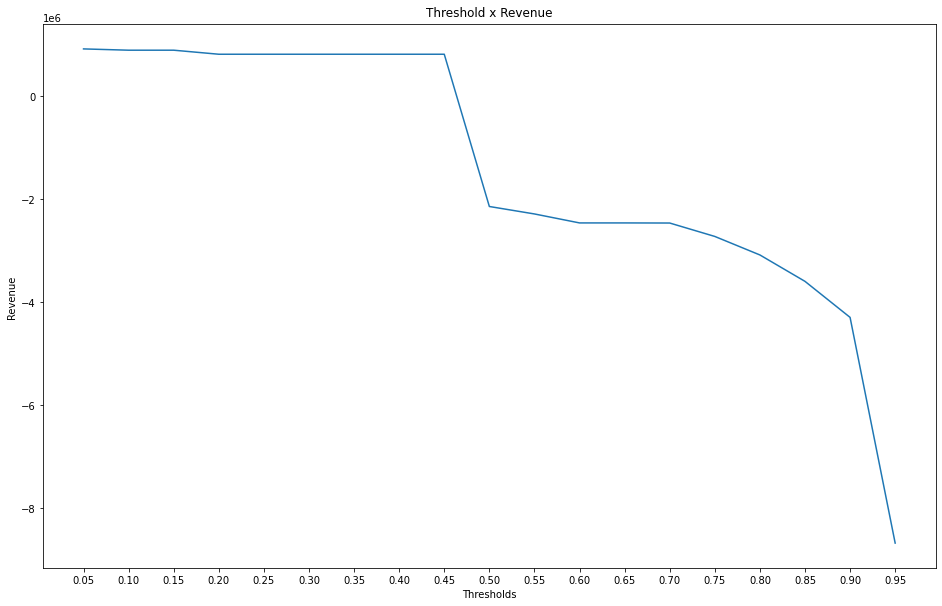

In [76]:
plt.figure(figsize=(16,10))
ax = sns.lineplot(x=np.arange(0.05,1,0.05),y=receita_list)
plt.xticks(np.arange(0.05,1,0.05))
ax.set_title('Threshold x Revenue',size=12,pad=8)
ax.set_xlabel('Thresholds',size=10)
ax.set_ylabel('Revenue',size=10)
plt.show()

## 9.3 Business Impact: Amount that was saved

In [79]:
y_pred = pd.Series(model.predict_proba(x_test)[:,1],name='proba').apply(lambda x: 1 if x>= 0.4 else 0)

accuracy = m.accuracy_score(y_test,y_pred)
precision = m.precision_score(y_test,y_pred)
recall = m.recall_score(y_test,y_pred)
f1_score = m.f1_score(y_test,y_pred)
roc_auc = m.roc_auc_score(y_test,y_pred)

print('Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nF1 Score: {:.3f}\nROC AUC: {:.3f}'.format(accuracy,precision,recall,f1_score,roc_auc))

Accuracy: 0.999
Precision: 0.491
Recall: 0.976
F1 Score: 0.653
ROC AUC: 0.987


In [80]:
aux1['amount'].sum() # Dinheiro que o modelo salvou

90520463.44

In [81]:
aux2['amount'].sum() # Dinheiro que o modelo não conseguiu salvar

102484.26

In [82]:
# O modelo salvou quantos % do valor que ia ser destinado a fraudes?
pct = round(aux1['amount'].sum()/(aux1['amount'].sum()+aux2['amount'].sum())*100,2)
print(f'{pct}%')

99.89%


# 10.0 Model Deploy

## 10.1 Fraud Class

In [292]:
import pandas as pd
import numpy as np
import inflection
import pickle as pkl

class Fraud():
    def __init__(self):
        self.le = pkl.load(open('pkl/le.pkl','rb'))
        self.ohe = pkl.load(open('pkl/ohe.pkl','rb'))
        self.mms = pkl.load(open('pkl/mms.pkl','rb'))
        
    def data_cleaning(self,dados):
        
        ## 2.1 Rename Values and Columns

        for column in dados.columns:
            dados.rename(columns={column:inflection.underscore(column)},inplace=True)

        dados['type'] = dados['type'].apply(lambda x: inflection.underscore(x))

        dados.rename(columns={'oldbalance_org':'old_balance_orig','newbalance_orig':'new_balance_orig','oldbalance_dest':'old_balance_dest','newbalance_dest':'new_balance_dest'},inplace=True)
        
        # podia usar um dados.fillna('algum valor ou média dos valores usando simple imputer')
        # pq se aparecer um dado faltante eu ns oq fazer e dará erro! (melhorar nisso talvez!)

        return dados
    
    def feature_engineering(self,dados):

        # Type of destination client
        dados['type_dest'] = dados['name_dest'].astype(str).str[0].map({'C':'customers','M':'merchants'})

        # If the origin account has lost or earned money or if nothing has changed in that transaction
        dados['orig_transaction_status'] = dados.apply(lambda x: 'orig_lost_money' if x['new_balance_orig']<x['old_balance_orig'] else ('no_change' if x['new_balance_orig']==x['old_balance_orig'] else 'orig_earned_money'),1)

        # If the destination account has lost or earned money or if nothing has changed in that transaction
        dados['dest_transaction_status'] = dados.apply(lambda x: 'dest_lost_money' if x['new_balance_dest']<x['old_balance_dest'] else ('no_change' if x['new_balance_dest']==x['old_balance_dest'] else 'dest_earned_money'),1)

        # Orig account has no money after the transaction
        dados['orig_has_no_money'] = dados['new_balance_orig'].apply(lambda x: 1 if x==0 else 0)

        # Dest account had no money before the transaction
        dados['dest_had_no_money'] = dados['old_balance_dest'].apply(lambda x: 1 if x==0 else 0)
        
        return dados
        
    def data_filtering(self,dados):

        dados.drop(['name_orig','name_dest'],1,inplace=True) # preciso da feature dest pra o feature engineering, a outra eu poderia nem filtrar, só não usar como input! (melhorar depois)
        
        return dados
    
    def data_preparation(self,dados):

        ## 6.2 Encoding

        # type (multiclass)
        dados = self.ohe.transform(dados).drop('type_debit',1)
        dados['type_dest'] = self.le.transform(dados['type_dest'])
        dados['dest_transaction_status'] = dados['dest_transaction_status'].map({'dest_earned_money':1, 'dest_lost_money':-1, 'no_change':0})
        dados['orig_transaction_status'] = dados['orig_transaction_status'].map({'orig_earned_money':1, 'orig_lost_money':-1, 'no_change':0})

        ## 6.4 Rescale

        columns = ['step', 'type_transfer', 'type_cash_out', 'type_payment','type_cash_in', 'amount', 'old_balance_orig', 'new_balance_orig','old_balance_dest', 'new_balance_dest', 'is_flagged_fraud', 'type_dest','orig_transaction_status', 'dest_transaction_status','orig_has_no_money', 'dest_had_no_money']
        dados = pd.DataFrame(self.mms.transform(dados),columns=columns)

        ## 6.5 Feature Selection

        cols_selected = ['step','old_balance_orig','new_balance_dest','dest_transaction_status','orig_transaction_status','amount','type_payment','type_transfer','type_dest','orig_has_no_money']
        dados = dados[cols_selected]
        
        return dados
    
    def get_predictions(self,model,dados):
        
        y_pred = pd.Series(model.predict_proba(x_test)[:,1],name='proba').apply(lambda x: 1 if x>= 0.4 else 0)
        return y_pred.to_json(orient='records')

## 10.2 Handler.py

In [315]:
from flask import Flask,request,Response
from fraud import Fraud
import pickle as pkl
import pandas as pd
import os

app = Flask(__name__)
@app.route('/predict',methods=['POST'])

def predict():
    json = request.get_json()
    
    if json:
        dados = pd.DataFrame(json)
        model = pkl.load(open('pkl/model.pkl','rb'))
        
        dados = Fraud().data_cleaning(dados)
        dados = Fraud().feature_engineering(dados)
        dados = Fraud().data_filtering(dados)
        dados = Fraud().data_preparation(dados)
        return Fraud().get_predictions(model,dados)
        
    else:
        Response('{}',status=200)
    
if __name__=='__main__':
    app.run(host='0.0.0.0',port=os.environ.get('PORT',8080),debug=False)

## 10.3 API Request Test

In [341]:
import requests
dados = pd.read_csv('/Users/nando/Comunidade DS/fraud/data/data.csv')
dados = dados.sample(3,random_state=101)
dados.drop('isFraud',1,inplace=True)
json = dados.to_json()

### 10.3.1 Local Request

In [342]:
response = requests.post(url='http://0.0.0.0:8080/predict',data=json,headers={'Content-type':'application/json'})
print(f'Status: {response.status_code}')
print(response.json())

Status: 200
[0, 0, 0]


### 10.3.2 Cloud Request

In [347]:
response = requests.post(url='https://fraud-detection-cds.herokuapp.com/predict',data=json,headers={'Content-type':'application/json'})
print(f'Status: {response.status_code}')
print(response.json())

Status: 200
[0, 0, 0]
